# Loading the Librarys

In [1]:
import pandas as pd
import numpy as np
# for data cleaning
import string
import re
# for removing accented and special chracters
import unicodedata
# for stopwords Removal
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
# for calculating Polarity and Subjectivity
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
# function for making ngrams
from nltk.util import ngrams
# load in all the modules we're going to need
import nltk
import collections
# for Wordscloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Read the data set

In [3]:
df=pd.read_csv('Reviews.csv')
df = df.head(2000)

In [4]:
# show some of data
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [6]:
# show the informatiom of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      2000 non-null   int64 
 1   ProductId               2000 non-null   object
 2   UserId                  2000 non-null   object
 3   ProfileName             2000 non-null   object
 4   HelpfulnessNumerator    2000 non-null   int64 
 5   HelpfulnessDenominator  2000 non-null   int64 
 6   Score                   2000 non-null   int64 
 7   Time                    2000 non-null   int64 
 8   Summary                 2000 non-null   object
 9   Text                    2000 non-null   object
dtypes: int64(5), object(5)
memory usage: 156.4+ KB


In [7]:
df['Text']

0       I have bought several of the Vitality canned d...
1       Product arrived labeled as Jumbo Salted Peanut...
2       This is a confection that has been around a fe...
3       If you are looking for the secret ingredient i...
4       Great taffy at a great price.  There was a wid...
                              ...                        
1995    I have to laugh at the reviews that said it wa...
1996    I had read some favorable reviews of this panc...
1997    I was expecting great things based on the revi...
1998    I love this pancake mix.  I bought my first ca...
1999    What can i say??  They are wonderful, and the ...
Name: Text, Length: 2000, dtype: object

# Clean the Dataset and Visualize the Distribution Data

In [8]:
rating_pct = df['Score'].value_counts()/len(df) * 100
rating_pct

Score
5    65.15
4    12.70
1     8.90
3     8.10
2     5.15
Name: count, dtype: float64

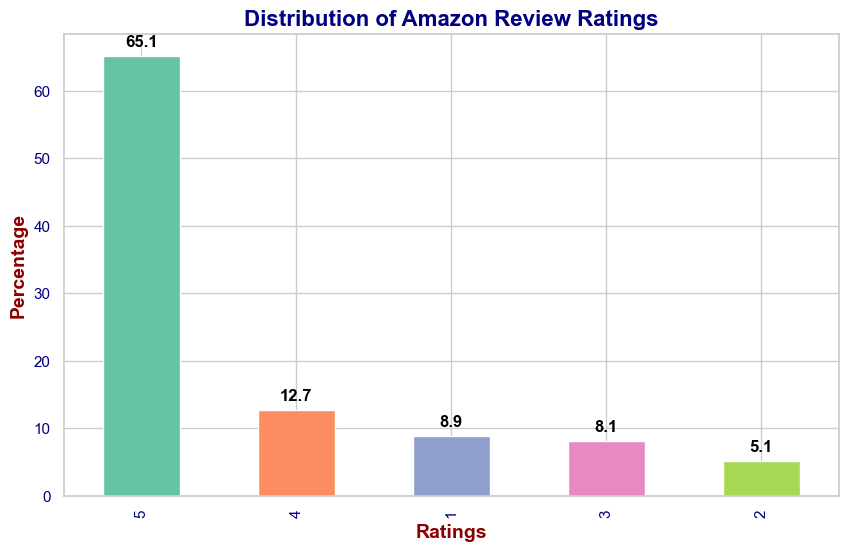

In [9]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = rating_pct.plot.bar(color=sns.color_palette("Set2"))

# Customize the plot
ax.set_title('Distribution of Amazon Review Ratings', fontsize=16, weight='bold', color='navy')
ax.set_xlabel('Ratings', fontsize=14, weight='bold', color='darkred')
ax.set_ylabel('Percentage', fontsize=14, weight='bold', color='darkred')
ax.tick_params(axis='x', colors='navy')
ax.tick_params(axis='y', colors='navy')

# Add value labels on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points',
                color='black', fontsize=12, weight='bold')

# Show the plot
plt.show()

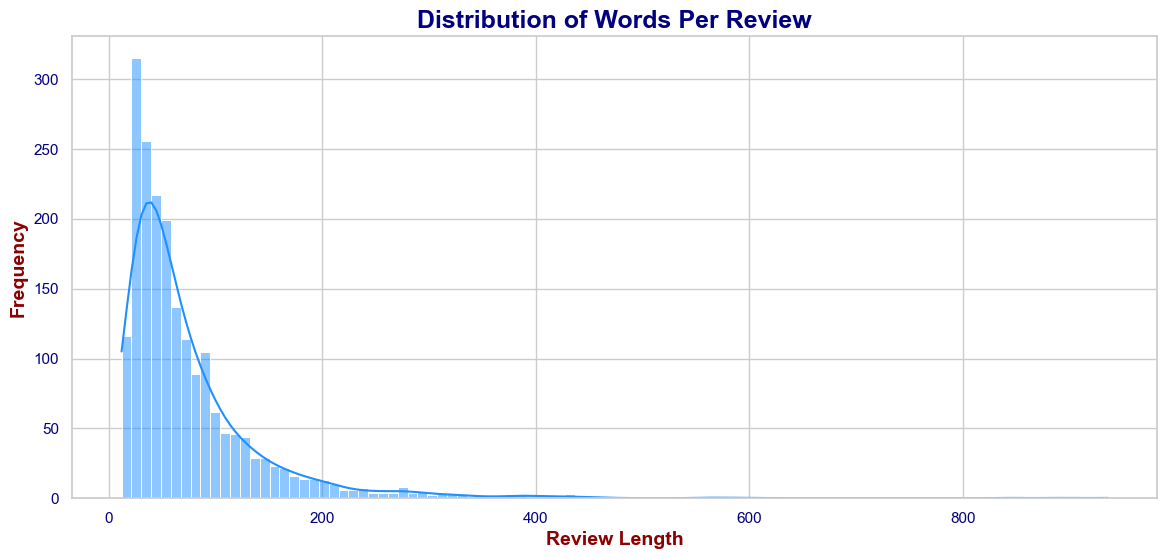

In [10]:
# Set the style for the plot
sns.set(style="whitegrid")

# Calculate words per review
words_per_review = df['Text'].apply(lambda x: len(x.split(' ')))

# Create the histogram plot
plt.figure(figsize=(14, 6))
ax = sns.histplot(words_per_review, bins=100, color='dodgerblue', kde=True)

# Customize the plot
ax.set_title('Distribution of Words Per Review', fontsize=18, weight='bold', color='navy')
ax.set_xlabel('Review Length', fontsize=14, weight='bold', color='darkred')
ax.set_ylabel('Frequency', fontsize=14, weight='bold', color='darkred')
ax.tick_params(axis='x', colors='navy')
ax.tick_params(axis='y', colors='navy')

# Show the plot
plt.show()

In [11]:
# First lets remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

df['Text'] = df['Text'].apply(punctuation_removal)

In [12]:
# lets make a function to remove Numbers from the reviews
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ''.join(list_text_new)

df['Text'] = df['Text'].apply(drop_numbers)

In [13]:
# lets show the Top 10 Reviews after Removal of Punctuations and Numbers
df['Text'].head(10)

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price  There was a wide...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good  It is very soft and che...
8    Right now Im mostly just sprouting this so my ...
9    This is a very healthy dog food Good for their...
Name: Text, dtype: object

In [14]:
### Removing Accented Characters

"""Accented characters are important elements which are used to signify emphasis on
a particular word during pronunciation or understanding. In some instances, 
the accent mark also clarifies the meaning of a word, which might be different without the accent.
While their use in English is largely limited but there are very good chances 
that you will come across accented characters/letters in a free text corpus. 
Words such as résumé, café, prótest, divorcé, 
coördinate, exposé, latté etc"""
# lets create a function to remove accented characters
def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

# lets apply the function
df['Text'] = df.apply(lambda x: remove_accented_chars(x['Text']), axis = 1)

In [15]:
# Create a function to remove special characters
def remove_special_characters(text):
    pat = r'[^a-zA-z0-9]' 
    return re.sub(pat, ' ', text)
 
# lets apply this function
df['Text'] = df.apply(lambda x: remove_special_characters(x['Text']), axis = 1)

In [16]:
df['Text'][:10]

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price  There was a wide...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good  It is very soft and che...
8    Right now Im mostly just sprouting this so my ...
9    This is a very healthy dog food Good for their...
Name: Text, dtype: object

# Feature Engineering

In [17]:
# lets check if the dataset has any Missing Values
# check for null values
df.isna().sum()


Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [18]:
df.dropna(inplace= True)
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [19]:
# Lets calculate the length of the Reviews
df['length'] = df['Text'].apply(len)

### Text Polarity

It is the expression that determines the sentimental aspect of an opinion. In textual data, the result of sentiment analysis can be determined for each entity in the sentence, document or sentence. The sentiment polarity can be determined as positive, negative and neutral.

In [20]:
# Lets calculate the Polarity of the Reviews
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
df['polarity'] = df['Text'].apply(get_polarity)

### Text Subjectivity

In natural language, subjectivity refers to expression of opinions, evaluations, feelings, and speculations and thus incorporates sentiment. Subjective text is further classified with sentiment or polarity.

In [21]:
# Lets calculate the Subjectvity of the Reviews
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
df['subjectivity'] = df['Text'].apply(get_subjectivity)

In [22]:
## lets summarize the Newly Created Features
df[['length','polarity','subjectivity']].describe()

,length,polarity,subjectivity
count,2000.000000,2000.000000,2000.000000
mean,383.607000,0.244176,0.553840
std,382.816223,0.223168,0.146968
min,56.000000,-1.000000,0.000000
25%,166.000000,0.109370,0.466738
50%,269.000000,0.237500,0.553364
75%,455.250000,0.375152,0.638471
max,4974.000000,1.000000,1.000000


In [23]:
# calculating the Character Count in the Reviews
df['char_count'] = df['Text'].apply(len)

In [24]:
# calculating the Word Count
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))

In [25]:
# Calculating the Word Density
df['word_density'] = df['char_count'] / (df['word_count']+1)

In [26]:
# importing the List of Punctuations
import string
punctuation = string.punctuation

# Calculating the Punctuation Count
df['punctuation_count'] = df['Text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 

In [27]:
## lets summarize the Newly Created Features
df[['char_count','word_count','word_density','punctuation_count']].describe()

,char_count,word_count,word_density,punctuation_count
count,2000.000000,2000.000000,2000.000000,2000.0
mean,383.607000,72.703000,5.140778,0.0
std,382.816223,70.437891,0.382494,0.0
min,56.000000,12.000000,3.500000,0.0
25%,166.000000,32.000000,4.907974,0.0
50%,269.000000,51.500000,5.116709,0.0
75%,455.250000,87.000000,5.356677,0.0
max,4974.000000,919.000000,7.866667,0.0


# Make Visulization

C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\859745405.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['polarity'])
C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\859745405.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['subjectivity'])


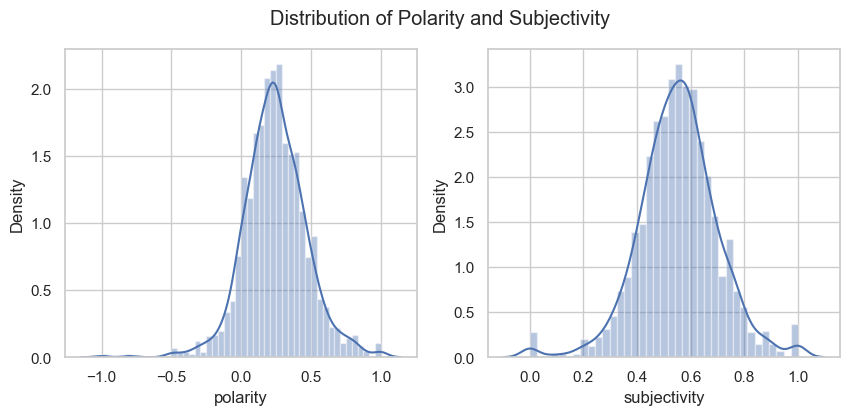

In [28]:
## Visualizing Polarity and Subjectivity

plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.distplot(df['polarity'])

plt.subplot(1, 2, 2)
sns.distplot(df['subjectivity'])

plt.suptitle('Distribution of Polarity and Subjectivity')
plt.show()

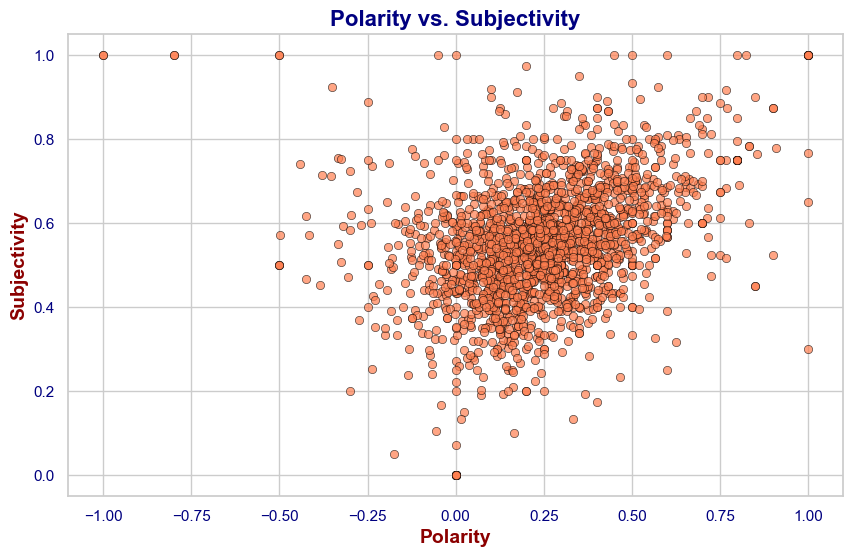

In [29]:

# Set the style for the plot
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x=df['polarity'], y=df['subjectivity'], color='coral', edgecolor='black', alpha=0.7)

# Customize the plot
ax.set_title('Polarity vs. Subjectivity', fontsize=16, weight='bold', color='navy')
ax.set_xlabel('Polarity', fontsize=14, weight='bold', color='darkred')
ax.set_ylabel('Subjectivity', fontsize=14, weight='bold', color='darkred')
ax.tick_params(axis='x', colors='navy')
ax.tick_params(axis='y', colors='navy')

# Show the plot
plt.show()

<Figure size 1500x600 with 0 Axes>

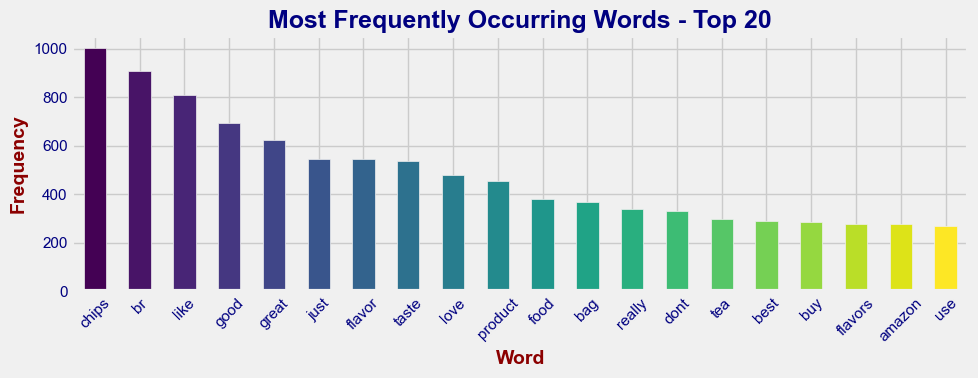

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df['Text'])
sum_words = words.sum(axis=0)

# Create a DataFrame with word frequencies
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

# Plot the most frequent words
plt.figure(figsize=(15, 6))
color = plt.cm.viridis(np.linspace(0, 1, 20))  # Use a different color map for better visual appeal
ax = frequency.head(20).plot(x='word', y='freq', kind='bar', color=color, legend=False)

# Customize the plot
ax.set_title("Most Frequently Occurring Words - Top 20", fontsize=18, weight='bold', color='navy')
ax.set_xlabel('Word', fontsize=14, weight='bold', color='darkred')
ax.set_ylabel('Frequency', fontsize=14, weight='bold', color='darkred')
ax.tick_params(axis='x', colors='navy', rotation=45)
ax.tick_params(axis='y', colors='navy')

# Show the plot
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

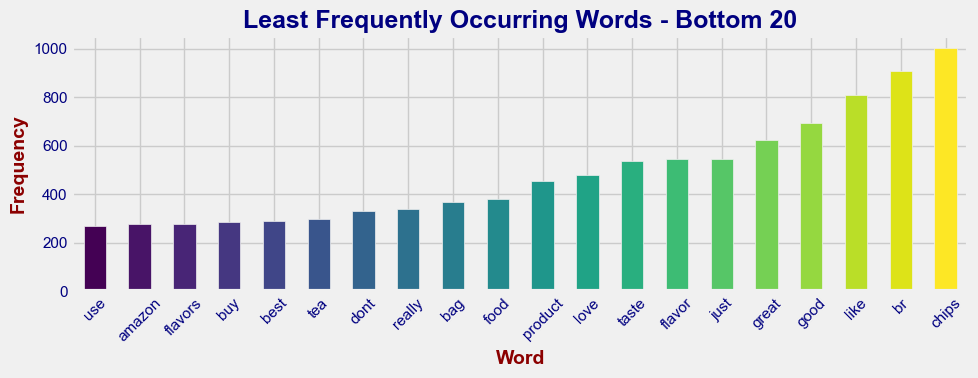

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df['Text'])
sum_words = words.sum(axis=0)

# Create a DataFrame with word frequencies
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=False)  # Sort in ascending order for least frequent
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

# Plot the least frequent words
plt.figure(figsize=(15, 6))
color = plt.cm.viridis(np.linspace(0, 1, 20))  # Use a color map for a more modern look
ax = frequency.tail(20).plot(x='word', y='freq', kind='bar', color=color, legend=False)

# Customize the plot
ax.set_title("Least Frequently Occurring Words - Bottom 20", fontsize=18, weight='bold', color='navy')
ax.set_xlabel('Word', fontsize=14, weight='bold', color='darkred')
ax.set_ylabel('Frequency', fontsize=14, weight='bold', color='darkred')
ax.tick_params(axis='x', colors='navy', rotation=45)
ax.tick_params(axis='y', colors='navy')

# Show the plot
plt.tight_layout()
plt.show()

# Visualizing the BiGrams

In [35]:
# Visualizing the BiGrams

text = str(df['Text'])
tokenized = text.split()

# and get a list of all the bi-grams
esBigrams = ngrams(tokenized, 2)

# get the frequency of each bigram in our corpus
esBigramFreq = collections.Counter(esBigrams)

# what are the ten most popular ngrams in this Spanish corpus?
esBigramFreq.most_common(10)

[(('I', 'have'), 2),
 (('0', 'I'), 1),
 (('have', 'bought'), 1),
 (('bought', 'several'), 1),
 (('several', 'of'), 1),
 (('of', 'the'), 1),
 (('the', 'Vitality'), 1),
 (('Vitality', 'canned'), 1),
 (('canned', 'd...'), 1),
 (('d...', '1'), 1)]

In [36]:
# Visualizing the Trigrams

text = str(df['Text'])
tokenized = text.split()

# and get a list of all the bi-grams
esTrigrams = ngrams(tokenized, 3)

# get the frequency of each bigram in our corpus
esTrigramFreq = collections.Counter(esTrigrams)

# what are the ten most popular ngrams in this Spanish corpus?
esTrigramFreq.most_common(10)

[(('0', 'I', 'have'), 1),
 (('I', 'have', 'bought'), 1),
 (('have', 'bought', 'several'), 1),
 (('bought', 'several', 'of'), 1),
 (('several', 'of', 'the'), 1),
 (('of', 'the', 'Vitality'), 1),
 (('the', 'Vitality', 'canned'), 1),
 (('Vitality', 'canned', 'd...'), 1),
 (('canned', 'd...', '1'), 1),
 (('d...', '1', 'Product'), 1)]

C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\2377661948.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Frequency', y='Bigram', data=top_bigrams, palette=color)
C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\2377661948.py:24: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x='Frequency', y='Bigram', data=top_bigrams, palette=color)


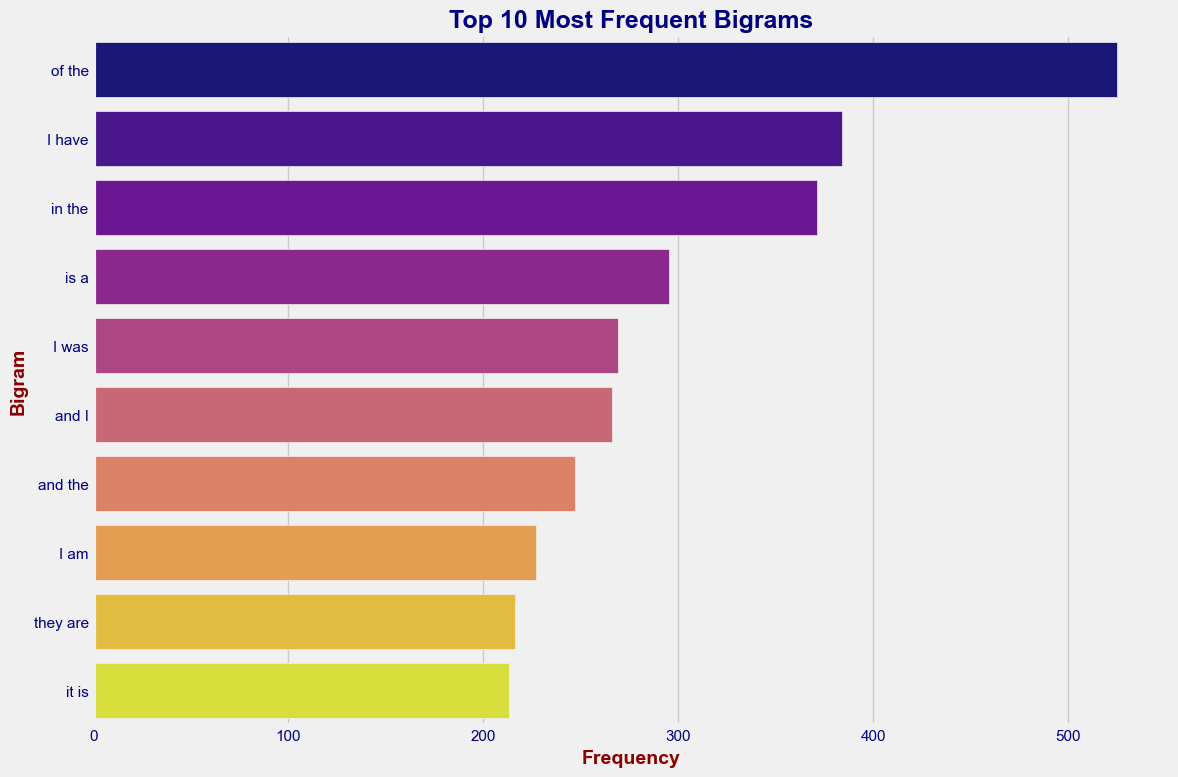

In [38]:

# Assuming df['Text'] contains the reviews and is a pandas Series
text = ' '.join(df['Text'].astype(str))  # Concatenate all texts into one string
tokenized = text.split()  # Tokenize the text

# Generate bigrams
bigrams = ngrams(tokenized, 2)

# Get the frequency of each bigram
bigram_freq = collections.Counter(bigrams)

# Convert bigram frequencies to a DataFrame
bigram_freq_df = pd.DataFrame(bigram_freq.items(), columns=['Bigram', 'Frequency'])
bigram_freq_df = bigram_freq_df.sort_values(by='Frequency', ascending=False)

# Extract the top 10 bigrams
top_bigrams = bigram_freq_df.head(10)

# Convert bigram tuples to string format for better plotting
top_bigrams.loc[:, 'Bigram'] = top_bigrams['Bigram'].apply(lambda x: ' '.join(x))

# Plot the most frequent bigrams
plt.figure(figsize=(12, 8))
color = plt.cm.plasma(np.linspace(0, 1, 10))  # Use a colormap as a list
ax = sns.barplot(x='Frequency', y='Bigram', data=top_bigrams, palette=color)

# Customize the plot
ax.set_title('Top 10 Most Frequent Bigrams', fontsize=18, weight='bold', color='navy')
ax.set_xlabel('Frequency', fontsize=14, weight='bold', color='darkred')
ax.set_ylabel('Bigram', fontsize=14, weight='bold', color='darkred')
ax.tick_params(axis='x', colors='navy')
ax.tick_params(axis='y', colors='navy')

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\1448147088.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Frequency', y='Trigram', data=top_trigrams, palette=color)
C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\1448147088.py:24: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x='Frequency', y='Trigram', data=top_trigrams, palette=color)


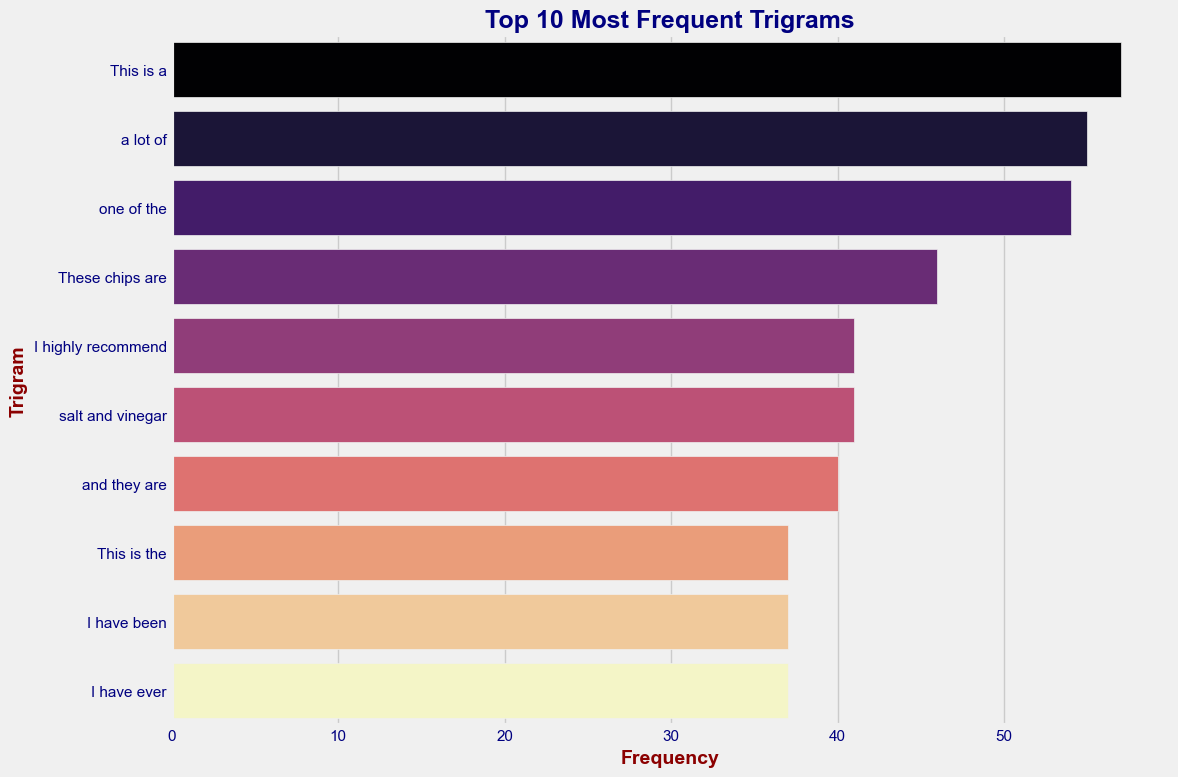

In [39]:

# Assuming df['Text'] contains the reviews and is a pandas Series
text = ' '.join(df['Text'].astype(str))  # Concatenate all texts into one string
tokenized = text.split()  # Tokenize the text

# Generate trigrams
trigrams = ngrams(tokenized, 3)

# Get the frequency of each trigram
trigram_freq = collections.Counter(trigrams)

# Convert trigram frequencies to a DataFrame
trigram_freq_df = pd.DataFrame(trigram_freq.items(), columns=['Trigram', 'Frequency'])
trigram_freq_df = trigram_freq_df.sort_values(by='Frequency', ascending=False)

# Extract the top 10 trigrams
top_trigrams = trigram_freq_df.head(10)

# Convert trigram tuples to string format for better plotting
top_trigrams.loc[:, 'Trigram'] = top_trigrams['Trigram'].apply(lambda x: ' '.join(x))

# Plot the most frequent trigrams
plt.figure(figsize=(12, 8))
color = plt.cm.magma(np.linspace(0, 1, 10))  # Use a different colormap for distinction
ax = sns.barplot(x='Frequency', y='Trigram', data=top_trigrams, palette=color)

# Customize the plot
ax.set_title('Top 10 Most Frequent Trigrams', fontsize=18, weight='bold', color='navy')
ax.set_xlabel('Frequency', fontsize=14, weight='bold', color='darkred')
ax.set_ylabel('Trigram', fontsize=14, weight='bold', color='darkred')
ax.tick_params(axis='x', colors='navy')
ax.tick_params(axis='y', colors='navy')

# Show the plot
plt.tight_layout()
plt.show()

In [40]:
# Defining a function to visualise n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\4165014708.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=y, y=x, palette=color)
C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\4165014708.py:28: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x=y, y=x, palette=color)


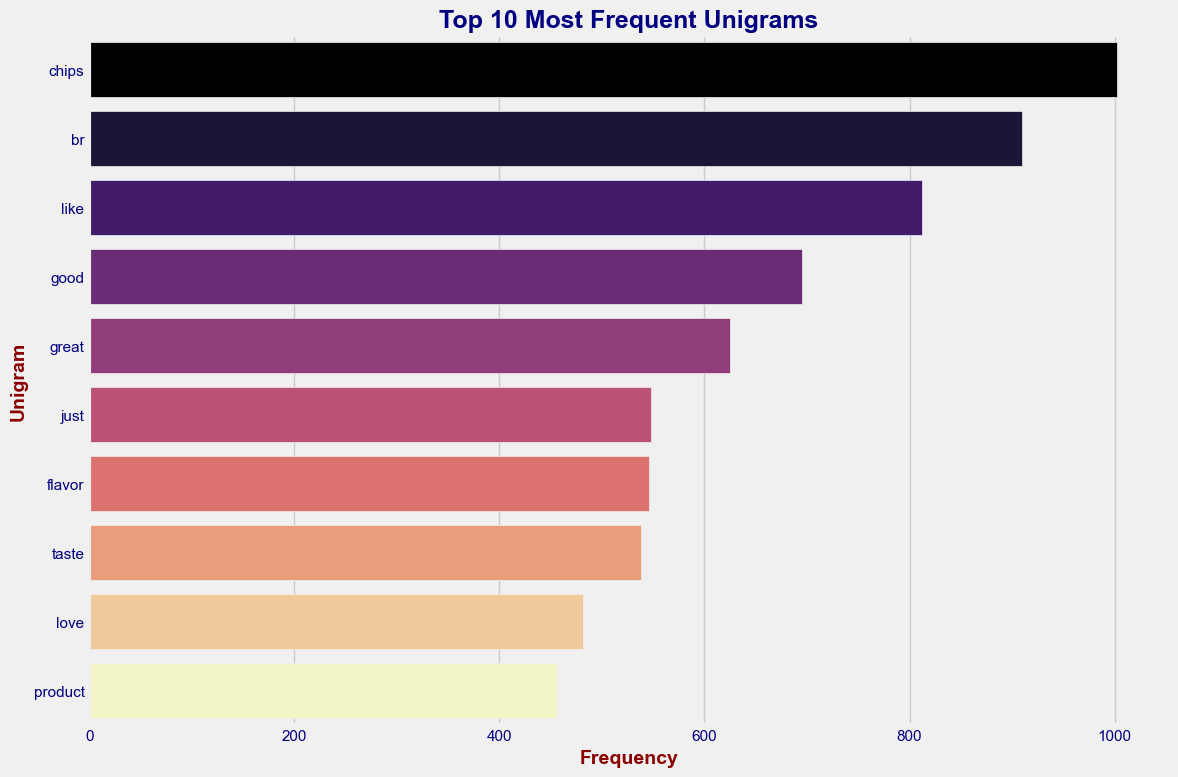

In [41]:

def get_top_ngram(text_series, n):
    """
    Extract the top n-grams from the text data.
    
    Parameters:
        text_series (pd.Series): Series of text data.
        n (int): The 'n' in n-grams.
        
    Returns:
        list of tuples: List containing n-grams and their frequencies, sorted in descending order.
    """
    cv = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = cv.fit_transform(text_series)
    sum_ngrams = ngrams.sum(axis=0)
    
    ngram_freq = [(ngram, sum_ngrams[0, idx]) for ngram, idx in cv.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
    
    return ngram_freq

# Assuming df['Text'] contains the tweets and is a pandas Series
top_unigrams = get_top_ngram(df['Text'], 1)[:10]
x, y = map(list, zip(*top_unigrams))

# Plot the most frequent unigrams
plt.figure(figsize=(12, 8))
color = plt.cm.magma(np.linspace(0, 1, 10))  # Use a color map for better visualization
ax = sns.barplot(x=y, y=x, palette=color)

# Customize the plot
ax.set_title('Top 10 Most Frequent Unigrams', fontsize=18, weight='bold', color='navy')
ax.set_xlabel('Frequency', fontsize=14, weight='bold', color='darkred')
ax.set_ylabel('Unigram', fontsize=14, weight='bold', color='darkred')
ax.tick_params(axis='x', colors='navy')
ax.tick_params(axis='y', colors='navy')

# Show the plot
plt.tight_layout()
plt.show()

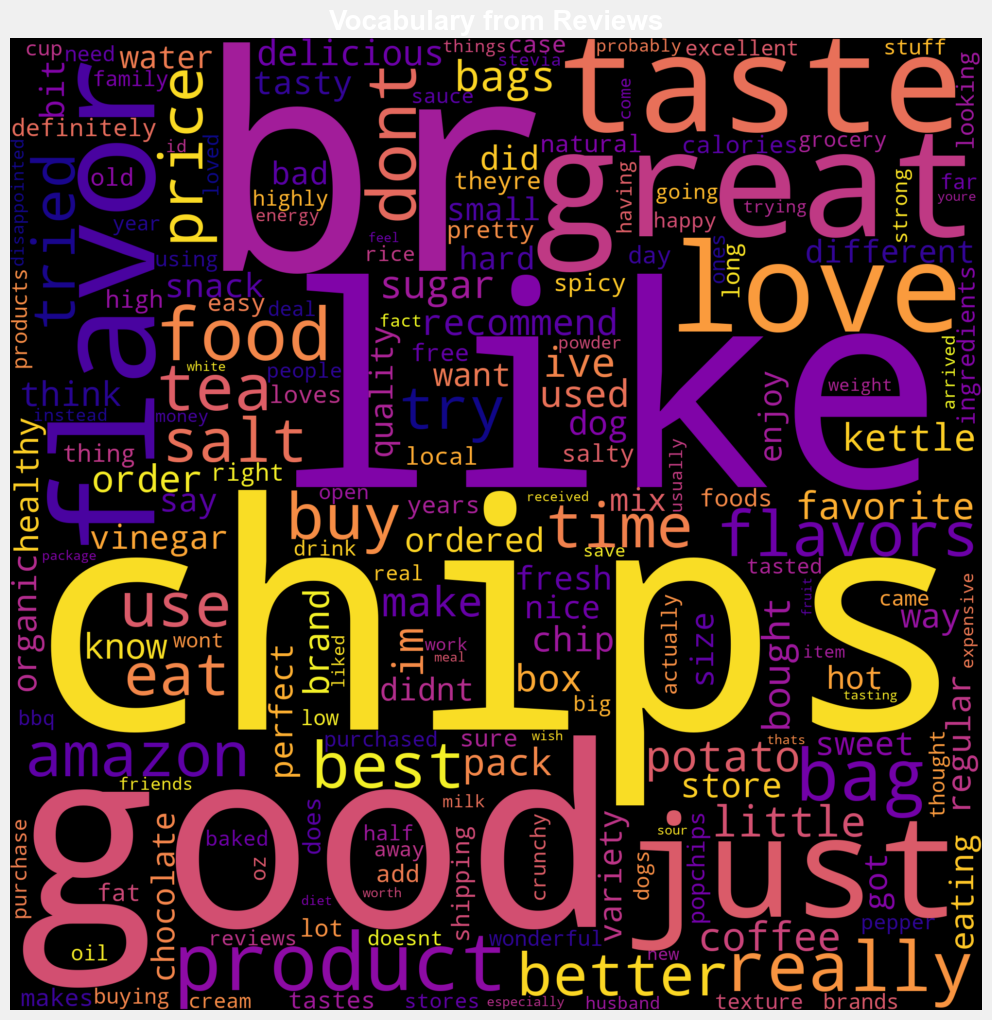

In [42]:

# Initialize CountVectorizer
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df['Text'])
sum_words = words.sum(axis=0)

# Get word frequencies
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Generate the word cloud
wordcloud = WordCloud(
    background_color='black',
    width=2000,
    height=2000,
    colormap='plasma'  # Change color map to enhance visual appeal
).generate_from_frequencies(dict(words_freq))

# Plot the word cloud
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title("Vocabulary from Reviews", fontsize=20, weight='bold', color='white')
plt.show()

# Show The Sentiment Analysis

In [43]:

def get_polarity(text):
    """
    Determine the polarity of a given text and categorize it.

    Parameters:
        text (str): The text for which to determine sentiment.

    Returns:
        str: The sentiment category based on polarity.
    """
    textblob = TextBlob(str(text))
    pol = textblob.sentiment.polarity
    
    if pol == 0:
        return "Neutral"
    elif 0 < pol <= 0.3:
        return "Weakly Positive"
    elif 0.3 < pol <= 0.6:
        return "Positive"
    elif 0.6 < pol <= 1:
        return "Strongly Positive"
    elif -0.3 < pol <= 0:
        return "Weakly Negative"
    elif -0.6 < pol <= -0.3:
        return "Negative"
    elif -1 <= pol < -0.6:
        return "Strongly Negative"

# Apply the function to the DataFrame
df['polarity'] = df['Text'].apply(get_polarity)

In [44]:
df['polarity'].value_counts()

polarity
Weakly Positive      1033
Positive              635
Weakly Negative       173
Strongly Positive      99
Neutral                33
Negative               23
Strongly Negative       4
Name: count, dtype: int64

In [45]:

# Initialize counters
neutral = 0
wpositive = 0
spositive = 0
positive = 0
negative = 0
wnegative = 0
snegative = 0
polarity_sum = 0

# Define a function to categorize polarity
def categorize_polarity(text):
    textblob = TextBlob(str(text))
    pol = textblob.sentiment.polarity
    global polarity_sum
    polarity_sum += pol
    if pol == 0:
        return 'Neutral'
    elif 0 < pol <= 0.3:
        return 'Weakly Positive'
    elif 0.3 < pol <= 0.6:
        return 'Positive'
    elif 0.6 < pol <= 1:
        return 'Strongly Positive'
    elif -0.3 < pol <= 0:
        return 'Weakly Negative'
    elif -0.6 < pol <= -0.3:
        return 'Negative'
    elif -1 <= pol < -0.6:
        return 'Strongly Negative'

# Apply categorization to the DataFrame and count categories
df['polarity_category'] = df['Text'].apply(categorize_polarity)
category_counts = df['polarity_category'].value_counts()

# Update counters based on category counts
neutral = category_counts.get('Neutral', 0)
wpositive = category_counts.get('Weakly Positive', 0)
positive = category_counts.get('Positive', 0)
spositive = category_counts.get('Strongly Positive', 0)
wnegative = category_counts.get('Weakly Negative', 0)
negative = category_counts.get('Negative', 0)
snegative = category_counts.get('Strongly Negative', 0)

# Print the results
print(f"Neutral: {neutral}")
print(f"Weakly Positive: {wpositive}")
print(f"Positive: {positive}")
print(f"Strongly Positive: {spositive}")
print(f"Weakly Negative: {wnegative}")
print(f"Negative: {negative}")
print(f"Strongly Negative: {snegative}")
print(f"Average Polarity: {polarity_sum / len(df['Text'])}")

Neutral: 33
Weakly Positive: 1033
Positive: 635
Strongly Positive: 99
Weakly Negative: 173
Negative: 23
Strongly Negative: 4
Average Polarity: 0.24417613691969556


C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\2766221569.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Sentiment', data=df_sentiment, palette=color)
C:\Users\Nawaz\AppData\Local\Temp\ipykernel_5396\2766221569.py:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x='Count', y='Sentiment', data=df_sentiment, palette=color)


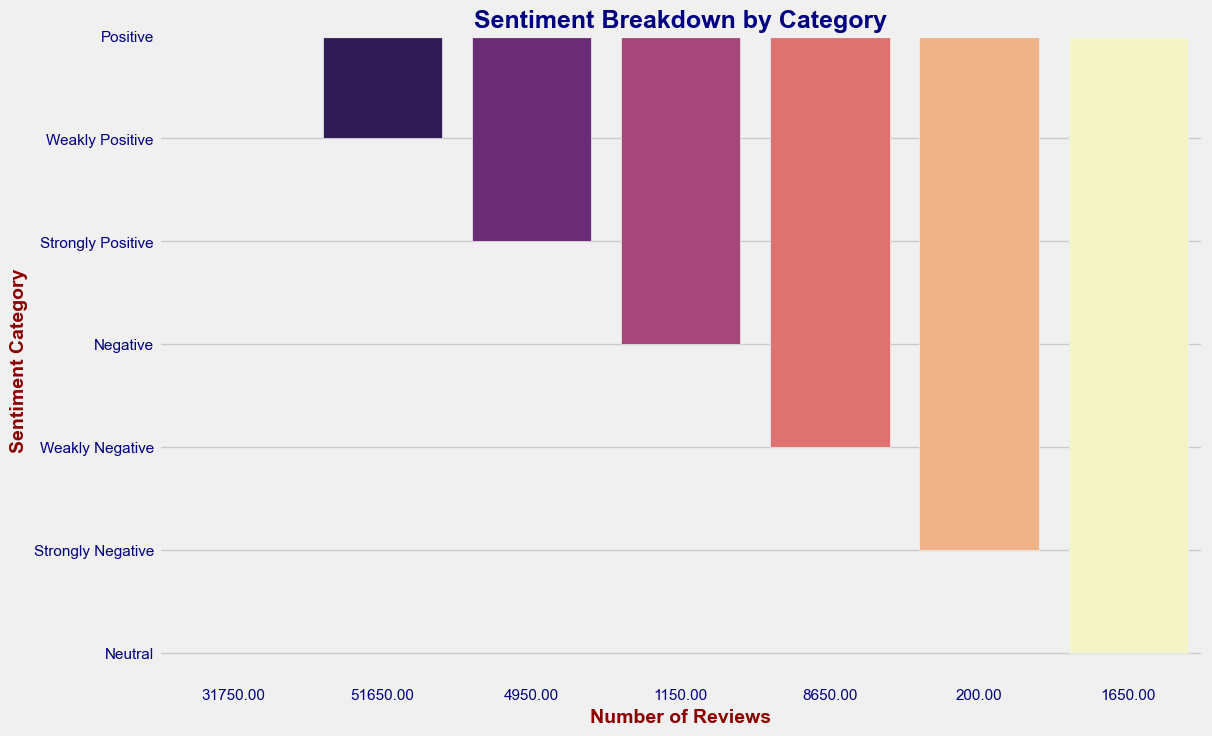

In [54]:

# Create a DataFrame for detailed sentiment
sentiment_data = {
    'Sentiment': ['Positive', 'Weakly Positive', 'Strongly Positive', 
                  'Negative', 'Weakly Negative', 'Strongly Negative', 'Neutral'],
    'Count': [positive, wpositive, spositive, negative, wnegative, snegative, neutral]
}

df_sentiment = pd.DataFrame(sentiment_data)

# Plot the bar chart
plt.figure(figsize=(12, 8))
color = plt.cm.magma(np.linspace(0, 1, len(df_sentiment)))
sns.barplot(x='Count', y='Sentiment', data=df_sentiment, palette=color)

# Customize the plot
plt.title('Sentiment Breakdown by Category', fontsize=18, weight='bold', color='navy')
plt.xlabel('Number of Reviews', fontsize=14, weight='bold', color='darkred')
plt.ylabel('Sentiment Category', fontsize=14, weight='bold', color='darkred')
plt.tick_params(axis='x', colors='navy')
plt.tick_params(axis='y', colors='navy')

plt.show()

In [47]:
# input for term to be searched and how many Review to search
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))

In [49]:
# finding average reaction
polarity = polarity_sum / NoOfTerms
polarity

244.17613691969555

In [50]:
# To calculate the Prsentage
def percentage(part, whole):
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')

In [51]:
 # finding average of how people are reacting
positive = percentage(positive, NoOfTerms)
wpositive = percentage(wpositive, NoOfTerms)
spositive = percentage(spositive, NoOfTerms)
negative = percentage(negative, NoOfTerms)
wnegative = percentage(wnegative, NoOfTerms)
snegative = percentage(snegative, NoOfTerms)
neutral = percentage(neutral, NoOfTerms)


In [55]:

# Initialize counters
neutral = 0
wpositive = 0
spositive = 0
positive = 0
negative = 0
wnegative = 0
snegative = 0
polarity_sum = 0

# Define a function to categorize polarity
def categorize_polarity(text):
    textblob = TextBlob(str(text))
    pol = textblob.sentiment.polarity
    global polarity_sum
    polarity_sum += pol
    if pol == 0:
        return 'Neutral'
    elif 0 < pol <= 0.3:
        return 'Weakly Positive'
    elif 0.3 < pol <= 0.6:
        return 'Positive'
    elif 0.6 < pol <= 1:
        return 'Strongly Positive'
    elif -0.3 < pol <= 0:
        return 'Weakly Negative'
    elif -0.6 < pol <= -0.3:
        return 'Negative'
    elif -1 <= pol < -0.6:
        return 'Strongly Negative'

# Apply categorization to the DataFrame and count categories
df['polarity_category'] = df['Text'].apply(categorize_polarity)
category_counts = df['polarity_category'].value_counts()

# Update counters based on category counts
neutral = category_counts.get('Neutral', 0)
wpositive = category_counts.get('Weakly Positive', 0)
positive = category_counts.get('Positive', 0)
spositive = category_counts.get('Strongly Positive', 0)
wnegative = category_counts.get('Weakly Negative', 0)
negative = category_counts.get('Negative', 0)
snegative = category_counts.get('Strongly Negative', 0)

# Calculate total reviews and ensure it's an integer
total_reviews = neutral + wpositive + spositive + positive + negative + wnegative + snegative
if not isinstance(total_reviews, int):
    total_reviews = int(total_reviews)

# Calculate percentages
def calculate_percentage(count, total):
    return (count / total) * 100 if total > 0 else 0

neutral_pct = calculate_percentage(neutral, total_reviews)
wpositive_pct = calculate_percentage(wpositive, total_reviews)
positive_pct = calculate_percentage(positive, total_reviews)
spositive_pct = calculate_percentage(spositive, total_reviews)
wnegative_pct = calculate_percentage(wnegative, total_reviews)
negative_pct = calculate_percentage(negative, total_reviews)
snegative_pct = calculate_percentage(snegative, total_reviews)

# Print the report
searchTerm = "Example Term"  # Replace with your actual search term
NoOfTerms = len(df)  # Total number of reviews
print(f"How people are reacting to '{searchTerm}' by analyzing {NoOfTerms} reviews.")
print()
print("-----------------------------------------------------------------------------------------")
print()
print("General Report: ")

# Calculate average polarity
average_polarity = polarity_sum / total_reviews if total_reviews > 0 else 0

if average_polarity == 0:
    print("Neutral")
elif 0 < average_polarity <= 0.3:
    print("Weakly Positive")
elif 0.3 < average_polarity <= 0.6:
    print("Positive")
elif 0.6 < average_polarity <= 1:
    print("Strongly Positive")
elif -0.3 < average_polarity <= 0:
    print("Weakly Negative")
elif -0.6 < average_polarity <= -0.3:
    print("Negative")
elif -1 <= average_polarity < -0.6:
    print("Strongly Negative")

print()
print("------------------------------------------------------------------------------------------")
print()
print("Detailed Report: ")
print(f"{positive_pct:.2f}% people thought it was positive")
print(f"{wpositive_pct:.2f}% people thought it was weakly positive")
print(f"{spositive_pct:.2f}% people thought it was strongly positive")
print(f"{negative_pct:.2f}% people thought it was negative")
print(f"{wnegative_pct:.2f}% people thought it was weakly negative")
print(f"{snegative_pct:.2f}% people thought it was strongly negative")
print(f"{neutral_pct:.2f}% people thought it was neutral")

How people are reacting to 'Example Term' by analyzing 2000 reviews.

-----------------------------------------------------------------------------------------

General Report: 
Weakly Positive

------------------------------------------------------------------------------------------

Detailed Report: 
31.75% people thought it was positive
51.65% people thought it was weakly positive
4.95% people thought it was strongly positive
1.15% people thought it was negative
8.65% people thought it was weakly negative
0.20% people thought it was strongly negative
1.65% people thought it was neutral


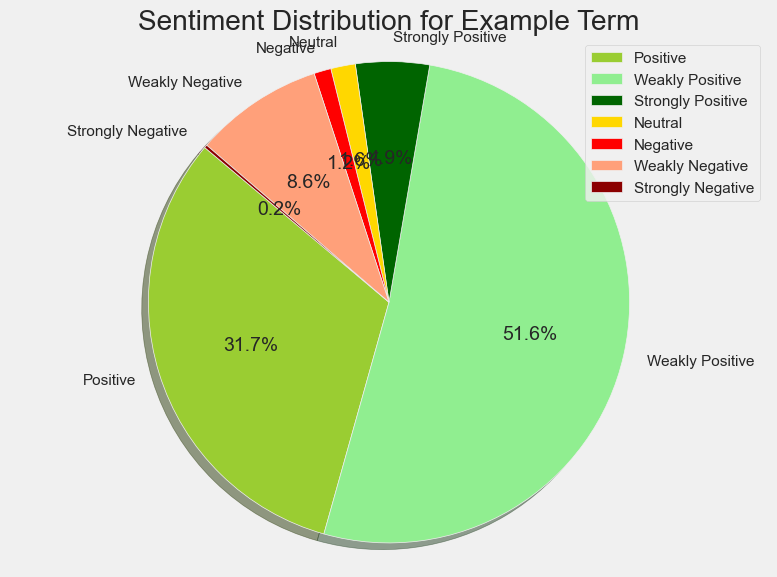

In [56]:
# Labels and sizes for the pie chart
sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
labels = ['Positive', 'Weakly Positive', 'Strongly Positive', 'Neutral', 'Negative', 'Weakly Negative', 'Strongly Negative']
colors = ['yellowgreen', 'lightgreen', 'darkgreen', 'gold', 'red', 'lightsalmon', 'darkred']

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Sentiment Distribution for ' + searchTerm)

# Add a legend
plt.legend(loc='best')

# Ensure the pie chart is circular
plt.axis('equal')

# Show the plot
plt.tight_layout()
plt.show()